In [1]:
import torch
import pandas as pd
import numpy as np
import albumentations as ATransforms
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
# from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF

import os
from tqdm import tqdm
from PIL import Image
import logging as log
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [3]:
log.basicConfig( level=log.INFO)

## Hyperparameters

In [4]:
EPOCHS = 120
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_WORKERS = 4

LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_FILE = "../models/model-1.pth"

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3


## Model Architecture

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [6]:
class UNET(nn.Module):
    def __init__(self, in_channels=IMAGE_CHANNELS, out_channels=IMAGE_CHANNELS):
        super(UNET, self).__init__()
        self.conv1 = DoubleConv(in_channels, 64)
        self.conv2 = DoubleConv(64, 128)
        self.conv3 = DoubleConv(128, 256)
        self.conv4 = DoubleConv(256, 512)
        self.conv5 = DoubleConv(512, 1024)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv6 = DoubleConv(1024, 512)
        self.conv7 = DoubleConv(512, 256) 
        self.conv8 = DoubleConv(256, 128)
        self.conv9 = DoubleConv(128, 64)

        self.tconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(1024, 1024)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        c1 = self.conv1(x)
        skip_connections.append(c1)
        c2 = self.conv2(self.maxpool(c1))
        skip_connections.append(c2)
        c3 = self.conv3(self.maxpool(c2))
        skip_connections.append(c3)
        c4 = self.conv4(self.maxpool(c3))
        skip_connections.append(c4)
        out = self.conv5(self.maxpool(c4))
        out = self.bottleneck(out) 
        skip_connections = skip_connections[::-1]
        out = self.tconv1(out)
        out = torch.cat([out, skip_connections[0]], dim=1)
        out = self.conv6(out)
        out = self.tconv2(out)
        out = torch.cat((out, skip_connections[1]), dim=1)
        out = self.conv7(out)
        out = self.tconv3(out)
        out = torch.cat((out, skip_connections[2]), dim=1)
        out = self.conv8(out)
        out = self.tconv4(out)
        out = torch.cat((out, skip_connections[3]), dim=1)
        out = self.conv9(out)

        out = self.out(out)
        return out
    

## Dataloader Preparation

In [7]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, normalize=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.normalize = normalize
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask > 0] = 1 # try with mask == 255.0
        if self.normalize is not None:
            norm_image = self.normalize(image=image)
            image = norm_image["image"]
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [8]:
augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ATransforms.Rotate(limit=35, p=1.0),
    ATransforms.HorizontalFlip(p=0.5),
    ATransforms.VerticalFlip(p=0.1),
    ToTensorV2(),
])

normalization = ATransforms.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            )

val_augmentations = ATransforms.Compose([
    ATransforms.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2(),
])

In [57]:
train_loader = DataLoader(
    PolypDataset('../data/train/images/', '../data/train/masks', transform=augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    PolypDataset('../data/val/images/', '../data/val/masks', transform=val_augmentations, normalize=normalization),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    PolypDataset('../data/test/images/', '../data/test/masks', transform=val_augmentations, normalize=normalization),
    batch_size = 1,
    shuffle = True,
    num_workers=NUM_WORKERS
)

## Train

In [10]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
if LOAD_MODEL : model.load_state_dict(torch.load(CHECKPOINT_FILE, map_location=DEVICE), strict=False)

In [43]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, bce=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.bce = bce

    def forward(self, pred, target):
        pred=pred.squeeze(1)
        target=target.squeeze(1)
        loss = self.IoU(pred, target) # IoU score
        loss = 1 - loss.mean() # mean over the batch
        if self.bce:
            criterion = nn.BCEWithLogitsLoss()
            bce = criterion(pred, target)
            loss += bce.mean()
        return loss
        
    def IoU(self, pred, target):
        intersection = (pred * target).sum(dim=(1,2)) # we are passing as batch of images, so sum only across height and width
        union = (pred + target).sum(dim=(1,2))
        iou = (intersection + self.smooth) / (union + self.smooth)
        threshold = torch.clamp(iou, 0, 10)/10.0
        return threshold

In [44]:
criterion = DiceLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-8)


In [45]:
def train():
    all_losses = []
    all_val_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        print(f"Epoch {epoch+1}/{EPOCHS}")
        model.train()
        for data, targets in tqdm(train_loader, colour="GREEN",unit="batch", desc="Train"):
            data = data.to(device=DEVICE)
            # targets = targets.float().unsqueeze(1).to(device=DEVICE)
            targets = targets.unsqueeze(1).to(DEVICE) # add channels dimension
            scores = model(data)
            loss = criterion(scores, targets)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        all_losses.append(total_loss/len(train_loader))
        # torch.save(model.state_dict(), CHECKPOINT_FILE)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for image, mask in tqdm(val_loader, desc="Valid", colour="YELLOW", unit="batch"):
                image = image.to(device=DEVICE)
                mask = mask.unsqueeze(1).to(DEVICE)
                pred = model(image)
                # pred = torch.sigmoid(model(image))
                # preds = (preds > 0.5).float()
                loss = criterion(pred, mask)
                total_val_loss += loss.item()
        all_val_losses.append(total_val_loss/len(val_loader))
        print(f"Train loss: {total_loss/len(train_loader)}, Val loss: {total_val_loss/len(val_loader)}\n")

    return all_losses, all_val_losses



In [46]:
train_loss, val_loss = train()
print("Training Done!")

Epoch 1/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.27batch/s]


Train loss: 1.3704570456156655, Val loss: 1.3210975612912859

Epoch 2/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.23batch/s]


Train loss: 1.3370765750370328, Val loss: 1.275526966367449

Epoch 3/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.19batch/s]


Train loss: 1.3278347083500452, Val loss: 1.3279757840292794

Epoch 4/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Train loss: 1.3234493278321766, Val loss: 1.2009626967566354

Epoch 5/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.3165826229822069, Val loss: 1.4610052108764648

Epoch 6/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.34batch/s]


Train loss: 1.3153515675711254, Val loss: 1.239811726978847

Epoch 7/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Train loss: 1.3103508930357675, Val loss: 1.2115404265267509

Epoch 8/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.21batch/s]


Train loss: 1.3052610385985601, Val loss: 1.230927893093654

Epoch 9/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.20batch/s]


Train loss: 1.2972177872582087, Val loss: 1.2051529373441423

Epoch 10/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.2923110609962827, Val loss: 1.3010743345533098

Epoch 11/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.2880150022960843, Val loss: 1.2037576266697474

Epoch 12/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.11batch/s]


Train loss: 1.2774588267008464, Val loss: 1.2456054176603044

Epoch 13/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.2685431336599684, Val loss: 1.1949759381158012

Epoch 14/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.2706878279882765, Val loss: 1.223287548337664

Epoch 15/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Train loss: 1.2618128118060885, Val loss: 1.1990574768611364

Epoch 16/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.2623637914657593, Val loss: 1.2255400930132185

Epoch 17/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.2485292203842648, Val loss: 1.18560448714665

Epoch 18/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.33batch/s]


Train loss: 1.2514897509226723, Val loss: 1.2067263977868217

Epoch 19/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.2403300849218217, Val loss: 1.2113383156912667

Epoch 20/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.2355954174011472, Val loss: 1.2101019620895386

Epoch 21/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.19batch/s]


Train loss: 1.2371502887635004, Val loss: 1.1665295362472534

Epoch 22/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.2195827733902704, Val loss: 1.2736669438225883

Epoch 23/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.08batch/s]


Train loss: 1.216699649417211, Val loss: 1.178897159440177

Epoch 24/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.2178509462447393, Val loss: 1.151463849203927

Epoch 25/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.20batch/s]


Train loss: 1.2059545573734103, Val loss: 1.1786567653928484

Epoch 26/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.38batch/s]


Train loss: 1.2039674028517708, Val loss: 1.1610432863235474

Epoch 27/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.31batch/s]


Train loss: 1.196910192096044, Val loss: 1.1598554849624634

Epoch 28/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.1909907961648607, Val loss: 1.1597871099199568

Epoch 29/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.1889839929247659, Val loss: 1.123335702078683

Epoch 30/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.21batch/s]


Train loss: 1.1900116886411394, Val loss: 1.1888192551476615

Epoch 31/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  5.98batch/s]


Train loss: 1.1973454214277721, Val loss: 1.1977038383483887

Epoch 32/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.1984862562209841, Val loss: 1.1369662966047014

Epoch 33/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.27batch/s]


Train loss: 1.1962113475042677, Val loss: 1.1418951749801636

Epoch 34/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.05batch/s]


Train loss: 1.1905116826768904, Val loss: 1.1316877092633928

Epoch 35/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.34batch/s]


Train loss: 1.1801815903376018, Val loss: 1.131745457649231

Epoch 36/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.187668384067596, Val loss: 1.1292091267449516

Epoch 37/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s]


Train loss: 1.1705195847011747, Val loss: 1.114848562649318

Epoch 38/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s]


Train loss: 1.1750059846847776, Val loss: 1.1239102738244193

Epoch 39/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.1744061443540785, Val loss: 1.104898384639195

Epoch 40/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.31batch/s]


Train loss: 1.1639354342506045, Val loss: 1.1021690368652344

Epoch 41/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.31batch/s]


Train loss: 1.1569678158987136, Val loss: 1.138688291822161

Epoch 42/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.149554106924269, Val loss: 1.0989927053451538

Epoch 43/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.1504400003524053, Val loss: 1.0997771876198905

Epoch 44/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.08batch/s]


Train loss: 1.1471519526981173, Val loss: 1.1007263830729894

Epoch 45/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.41batch/s]


Train loss: 1.1514727539486356, Val loss: 1.1629913704735892

Epoch 46/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.1650451838024078, Val loss: 1.1227733407701765

Epoch 47/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.142973019963219, Val loss: 1.1145309039524622

Epoch 48/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.33batch/s]


Train loss: 1.1373149289025202, Val loss: 1.090820040021624

Epoch 49/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s]


Train loss: 1.135660169616578, Val loss: 1.098995872906276

Epoch 50/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.1550876261695984, Val loss: 1.1068442889622279

Epoch 51/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.42batch/s]


Train loss: 1.1418106272107078, Val loss: 1.1109331165041243

Epoch 52/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.1516178108396984, Val loss: 1.1018225976399012

Epoch 53/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.11batch/s]


Train loss: 1.134587598225427, Val loss: 1.088932888848441

Epoch 54/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.1264446557514252, Val loss: 1.0760085412434168

Epoch 55/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.1295842121517847, Val loss: 1.1073188441140311

Epoch 56/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.1220443362281436, Val loss: 1.0819053139005388

Epoch 57/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.1379935854957217, Val loss: 1.0767545700073242

Epoch 58/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  5.93batch/s]


Train loss: 1.1376375376232086, Val loss: 1.0822480065482003

Epoch 59/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.1258496973249648, Val loss: 1.0680691855294364

Epoch 60/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s]


Train loss: 1.1238657519930886, Val loss: 1.0801595790045602

Epoch 61/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Train loss: 1.1192844254629952, Val loss: 1.0672093629837036

Epoch 62/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.1176878686935183, Val loss: 1.0657648529325212

Epoch 63/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.1374132368299696, Val loss: 1.0755844286509924

Epoch 64/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.20batch/s]


Train loss: 1.1190318436849684, Val loss: 1.0840223516736711

Epoch 65/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.30batch/s]


Train loss: 1.1267072946306258, Val loss: 1.0800930602209908

Epoch 66/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.1182769612660484, Val loss: 1.0735458816800798

Epoch 67/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.1132862094848874, Val loss: 1.0715121201106481

Epoch 68/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.27batch/s]


Train loss: 1.1135398130568246, Val loss: 1.0679041487830025

Epoch 69/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.1134436963096497, Val loss: 1.0650722469602312

Epoch 70/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.1187411944071453, Val loss: 1.1317460877554757

Epoch 71/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  5.94batch/s]


Train loss: 1.1064722575838604, Val loss: 1.084172282900129

Epoch 72/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.106366609770154, Val loss: 1.066779613494873

Epoch 73/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.1033649255358984, Val loss: 1.0596306834902083

Epoch 74/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.06batch/s]


Train loss: 1.1065442278271629, Val loss: 1.060739312853132

Epoch 75/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.20batch/s]


Train loss: 1.102571345510937, Val loss: 1.0625488758087158

Epoch 76/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.23batch/s]


Train loss: 1.1039903712651087, Val loss: 1.0951464005878992

Epoch 77/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.36batch/s]


Train loss: 1.1020193364885118, Val loss: 1.0689749717712402

Epoch 78/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.09batch/s]


Train loss: 1.096920579198807, Val loss: 1.0629397800990514

Epoch 79/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s]


Train loss: 1.0933711528778076, Val loss: 1.057568039212908

Epoch 80/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.0928868736539568, Val loss: 1.0621690579823084

Epoch 81/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.10batch/s]


Train loss: 1.0940864369982766, Val loss: 1.058179565838405

Epoch 82/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.23batch/s]


Train loss: 1.0933522894268943, Val loss: 1.0553114243916102

Epoch 83/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s]


Train loss: 1.0993766538680545, Val loss: 1.066691313471113

Epoch 84/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.07batch/s]


Train loss: 1.1032541536149525, Val loss: 1.0518893684659685

Epoch 85/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.39batch/s]


Train loss: 1.0923291312323675, Val loss: 1.0603045054844447

Epoch 86/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.0953249515049042, Val loss: 1.0610620294298445

Epoch 87/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.18batch/s]


Train loss: 1.0936659782651872, Val loss: 1.0536679880959647

Epoch 88/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.32batch/s]


Train loss: 1.095606175680009, Val loss: 1.0555144378117152

Epoch 89/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.33batch/s]


Train loss: 1.0921392592172774, Val loss: 1.0632482426507133

Epoch 90/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.35batch/s]


Train loss: 1.0876692533493042, Val loss: 1.058780516896929

Epoch 91/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.17batch/s]


Train loss: 1.0859775259381248, Val loss: 1.0686682632991247

Epoch 92/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s]


Train loss: 1.0868309963317144, Val loss: 1.0491172926766532

Epoch 93/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.087760535497514, Val loss: 1.049485172544207

Epoch 94/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.19batch/s]


Train loss: 1.0832567120355272, Val loss: 1.047174607004438

Epoch 95/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.14batch/s]


Train loss: 1.081511758622669, Val loss: 1.0506978034973145

Epoch 96/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.0843771204115853, Val loss: 1.0534079926354545

Epoch 97/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.03batch/s]


Train loss: 1.08556249122771, Val loss: 1.0513787269592285

Epoch 98/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.16batch/s]


Train loss: 1.084016376071506, Val loss: 1.0483005728040422

Epoch 99/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.082070201162308, Val loss: 1.0528884615216936

Epoch 100/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.20batch/s]


Train loss: 1.077264890784309, Val loss: 1.0470204523631506

Epoch 101/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.27batch/s]


Train loss: 1.0802993641959295, Val loss: 1.0481507267270769

Epoch 102/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.23batch/s]


Train loss: 1.0788421006429763, Val loss: 1.0485190834317888

Epoch 103/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.19batch/s]


Train loss: 1.078656600581275, Val loss: 1.050177812576294

Epoch 104/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.09batch/s]


Train loss: 1.079432523439801, Val loss: 1.0469529799052648

Epoch 105/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.39batch/s]


Train loss: 1.0831936541057767, Val loss: 1.0474029779434204

Epoch 106/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.22batch/s]


Train loss: 1.0777630692436582, Val loss: 1.0582363775798254

Epoch 107/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.35batch/s]


Train loss: 1.081227699915568, Val loss: 1.0478169236864363

Epoch 108/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.24batch/s]


Train loss: 1.0774369788548304, Val loss: 1.0442442212785994

Epoch 109/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.21batch/s]


Train loss: 1.07773010314457, Val loss: 1.0459840638296944

Epoch 110/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.28batch/s]


Train loss: 1.0754429272242956, Val loss: 1.0446613005229406

Epoch 111/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.35batch/s]


Train loss: 1.0740455899919783, Val loss: 1.044621569769723

Epoch 112/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.0764482153786554, Val loss: 1.0468077659606934

Epoch 113/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.15batch/s]


Train loss: 1.0783016624904813, Val loss: 1.0459495612553187

Epoch 114/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.26batch/s]


Train loss: 1.0775524056147014, Val loss: 1.0648772716522217

Epoch 115/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.32batch/s]


Train loss: 1.076719844152057, Val loss: 1.043562991278512

Epoch 116/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.0724145949832977, Val loss: 1.0433440208435059

Epoch 117/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.25batch/s]


Train loss: 1.0768697924084134, Val loss: 1.0479926041194372

Epoch 118/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.29batch/s]


Train loss: 1.0775450070699055, Val loss: 1.043547340801784

Epoch 119/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.19batch/s]


Train loss: 1.0745807394148812, Val loss: 1.0446010998317175

Epoch 120/120


Valid: 100%|██████████| 7/7 [00:01<00:00,  6.36batch/s]

Train loss: 1.0757345150387476, Val loss: 1.0443612677710397

Training Done!


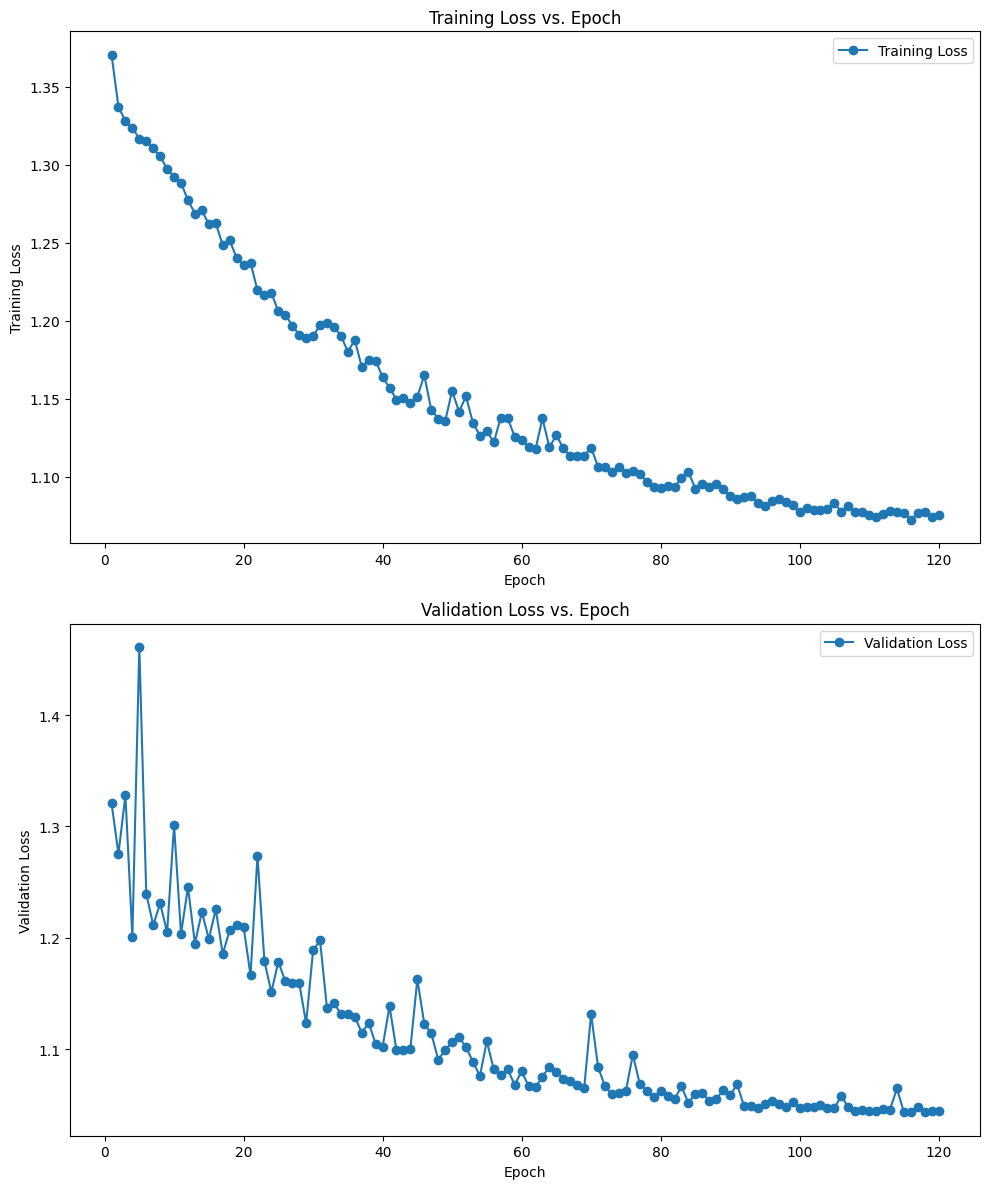

In [47]:
def plot_losses(train_loss, validation_loss):
    # Create an array of epoch numbers based on the length of the lists
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots for train loss, validation loss, and BLEU scores
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot training loss
    ax1.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss vs. Epoch')
    ax1.legend()

    # Plot validation loss
    ax2.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss vs. Epoch')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_losses(train_loss, val_loss)

In [48]:
torch.save(model.state_dict(), '../models/model-1.pth')

## Test

In [59]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for x, target in loader:
            x = x.to(DEVICE)
            target = target.unsqueeze(1).to(DEVICE)
            pred = model(x)
            loss = criterion(pred, target)
            total_loss += loss.item()
            # preds = torch.sigmoid(model(x))
            # preds = (preds > 0.5).float()
            # total += y.flatten().size(0)
            # correct += (preds == y).float().sum().item()
    return total_loss / len(loader)

In [62]:
criterion = DiceLoss()
iou = DiceLoss(bce=False)
bce = nn.BCEWithLogitsLoss()

test_loss = evaluate(model, test_loader, criterion)
print(f"Test loss (Dice Loss): {test_loss:.4f}")

test_loss_iou = evaluate(model, test_loader, iou)
print(f"Test loss (IoU Loss): {test_loss_iou:.4f}")

test_loss_bce = evaluate(model, test_loader, bce)
print(f"Test loss (BCE Loss): {test_loss_bce:.4f}")

Test loss (Dice Loss): 1.0509
Test loss (IoU Loss): 1.0000
Test loss (BCE Loss): 0.0509


## Test Images

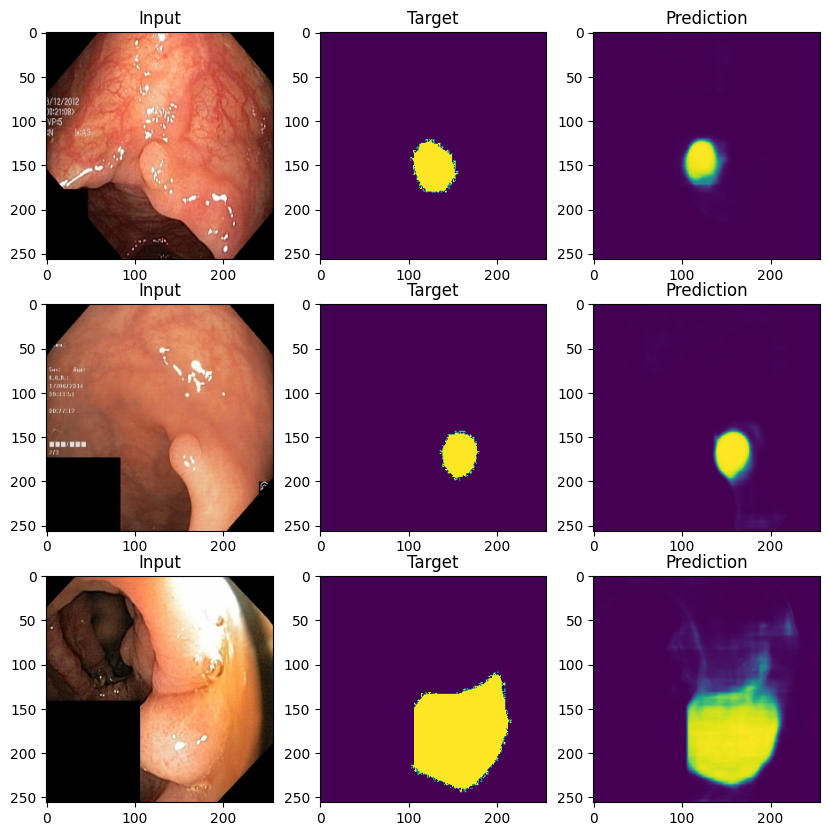

In [70]:
row_i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
model.eval()
for image, target in test_loader:
    image = image.to(DEVICE)
    target = target.unsqueeze(1).to(DEVICE)
    pred = model(image)
    pred = torch.sigmoid(pred)
    # pred = (pred > 0.5).float()
    axes[row_i, 0].imshow(image[0].permute(1, 2, 0).cpu())
    axes[row_i, 0].set_title("Input")
    axes[row_i, 1].imshow(target[0].squeeze(0).cpu())
    axes[row_i, 1].set_title("Target")
    axes[row_i, 2].imshow(pred[0].squeeze(0).cpu().detach().numpy())
    axes[row_i, 2].set_title("Prediction")
    if row_i == 2:
        break   
    row_i += 1